In this notebook, we will apply the information-matching method to find the optimal PMU placements that leads to full system observability.
The objective is translated to requiring non-singular FIM of the system.
In practice, we set the target FIM to be a diagonal matrix, where the diagonal element is set to be some small positive number.
By doing this, the eigenvalues of the optimal FIM are larger than this small number, and thus the FIM is non-singular.

Details of the calculation:
* Model: IEEE 14-bus system
* Candidate data: Voltage phasor at each bus
* Eigenvalue cutoff: 1e-5

In [1]:
from pathlib import Path

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from information_matching.convex_optimization import ConvexOpt
from information_matching.utils import tol, eps

%matplotlib inline
plt.style.use("default")

In [2]:
# Set directories
case = 14  # 14-bus case

WORK_DIR = Path().absolute()
FIM_DIR = WORK_DIR / "FIMs"

# Setup

In [3]:
# Model information
nparams = 2 * case

In [4]:
# Configurations
nconfigs = case
configs = np.arange(case) + 1
# Identifier of the configurations/data
config_ids = np.array([f"bus{ii}" for ii in configs])

In [5]:
# Load configuration FIMs
fim_configs_tensor = np.empty((nconfigs, nparams, nparams))
for ii, bus in enumerate(configs):
    I = np.loadtxt(FIM_DIR / f"fim_bus{bus}.csv", delimiter=",")
    fim_configs_tensor[ii] = I
# Scaling factor to help the convex optimization
norm = max(np.linalg.norm(fim_configs_tensor, axis=(1, 2)))
fim_configs_tensor[0].shape

(28, 28)

In [6]:
# Target FIM
lambda_tol = 1e-5  # Eigenvalue cutoff
fim_target = np.diag(np.ones(nparams)) * lambda_tol
print("Eigenvalue lower bound:", lambda_tol)

Eigenvalue lower bound: 1e-05


# Convex optimization

Additional note:

We will perform the optimization iteratively.
In each iteration, we scale the weights being optimize by the optimal weights from the previous iteration.
By doing so, the objective function in the convex optimization better mimics $\ell_0$-norm to enforce sparsity.

In [7]:
# Construct the input FIMs
# FIM target is fine, because we only apply scale 1.0
# FIM configs
fim_configs = {}
for ii, identifier in enumerate(config_ids):
    fim_configs.update(
        {identifier: {"fim": fim_configs_tensor[ii], "fim_scale": 1 / norm}}
    )

In [8]:
# Before running the optimization, we have performed similar calculation, but with
# Mixed-integer semi-definite programming (MISDP) problem in Matlab. That result can
# be used as an initial guess to speed up the calculation here. As suppose to the
# MISDP version of the method, the regular SDP version can find continuous values.
opt_buses_misdp = np.loadtxt(
    WORK_DIR / "data" / "misdp_optimal_buses.txt", delimiter=",", dtype=int
)
opt_buses_misdp_idx = opt_buses_misdp - 1

Tolerance: 1.8189894035458565e-12
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 1.000000097361994e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp
Violation: 2.684322636824387e-08
Step length is too small.  :: line 198 in sdpa_dataset.cpp
cannot move: step length is too short :: line 190 in sdpa_solve.cpp


/home/yonatank/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Optimal value: 2.5352213848002387


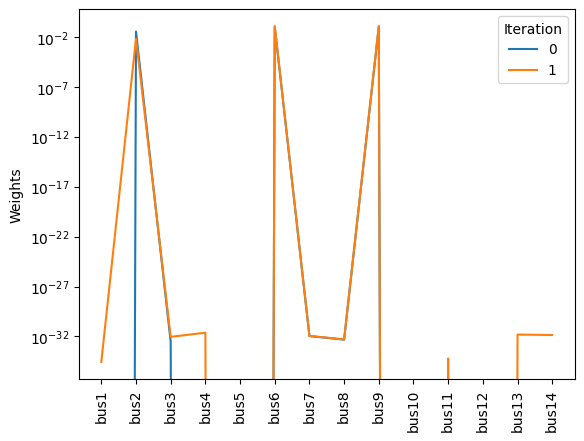

In [9]:
# Convex optimization
# Settings
cvx_tol = eps ** 0.75
solver = dict(verbose=False, warm_start=True, solver=cp.SDPA, epsilonStar=cvx_tol)
print("Tolerance:", cvx_tol)

plt.figure()
# Use the MISDP result as an initial guess
wopt = np.zeros(nconfigs)
wopt[opt_buses_misdp_idx] = 1.0
for ii in range(10):
    # Update the weight scales
    for jj, identifier in enumerate(config_ids):
        # Add weight scale information,aAdd some small number for numerical stability
        fim_configs[identifier].update({"weight_scale": 1 / (wopt[jj] + 1e-15)})
    cvxopt = ConvexOpt(fim_target, fim_configs, l1norm_obj=True)

    try:
        # Solve
        if ii == 0:
            cvxopt.wm.value = wopt.reshape((-1, 1))
        cvxopt.solve(**solver)
        result = cvxopt.result.copy()
        wopt = result["wm"]
        dual = result["dual_wm"]
        print("Violation:", cvxopt.constraints[1].violation())
    except Exception:
        cvxopt.result = result
        break

    plt.plot(wopt, label=ii)

print("Optimal value:", result["value"])

plt.yscale("log")
plt.xticks(range(nconfigs), config_ids, rotation=90)
plt.ylabel("Weights")
plt.legend(title="Iteration", bbox_to_anchor=(1, 1))
plt.show()

## Post-processing

In [10]:
# Get the optimal buses
# Index to the optimal buses
idx_wopt = cvxopt._get_idx_nonzero_wm(cvx_tol ** 0.5, cvx_tol ** 0.5)
print("Optimal buses:")
_ = [print(f'{config_ids[ii]} \t {wopt[ii]}') for ii in idx_wopt]

Optimal buses:
bus9 	 0.12781025060677245
bus2 	 0.006712350061736481
bus6 	 0.12372280057147214


Next, let's investigate whether these 3 buses are really sufficient.
To do this, we will compute the FIM of the configurations as we add more and more configurations, starting from the most optimal ones.
Then, we will compare the smallest eigenvalue of this FIM with the cutoff we set in the target FIM. 

Buses sorted by weight magnitude: 
 [ 9  6  2  4 13 14  7  3  8 11  1 12  5 10]


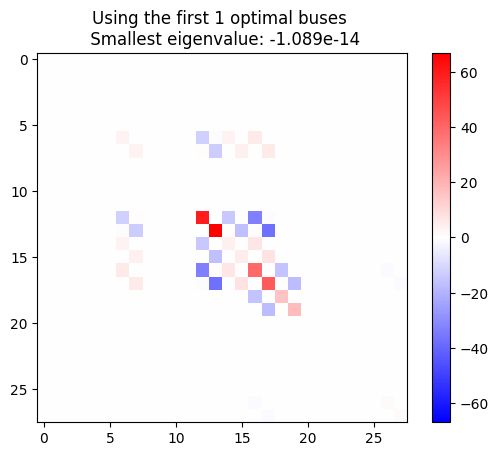

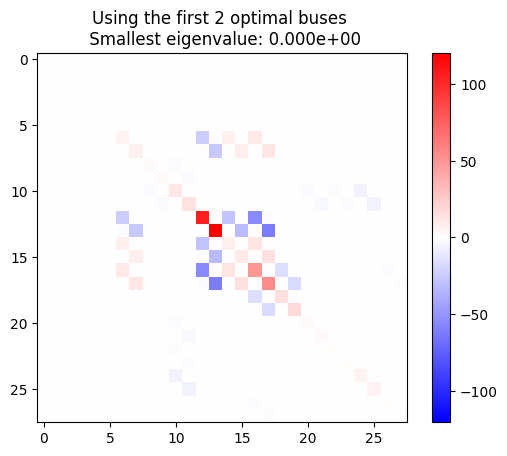

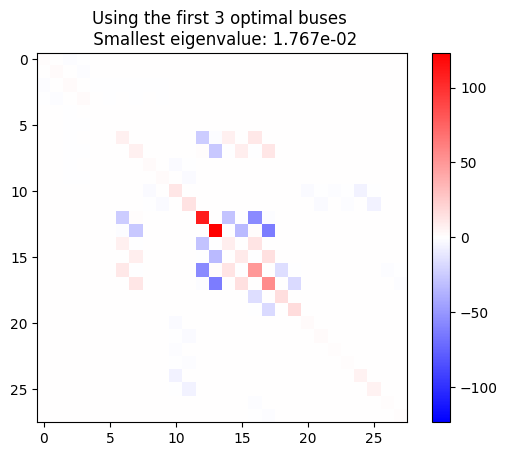

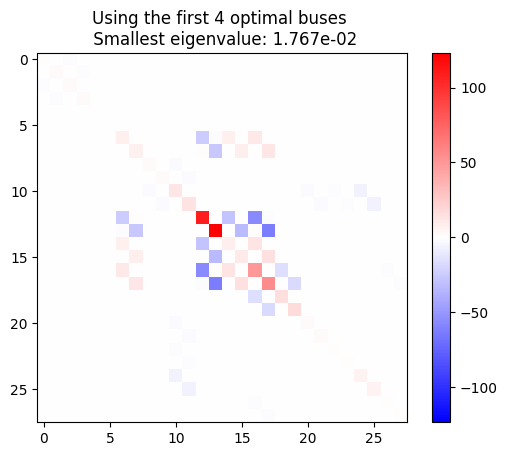

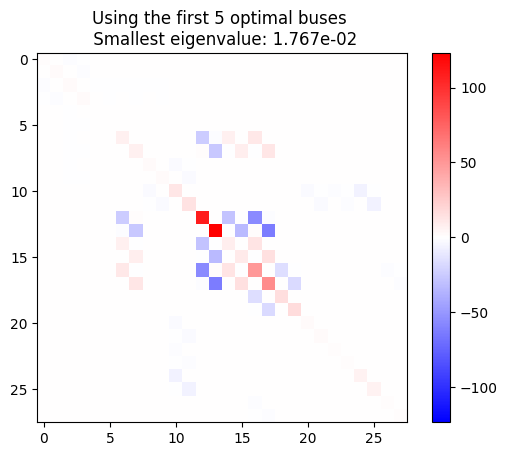

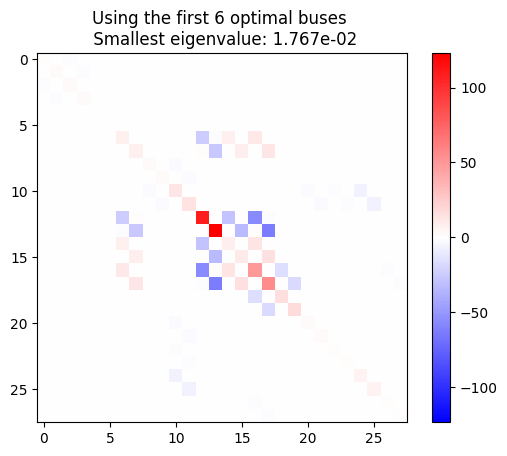

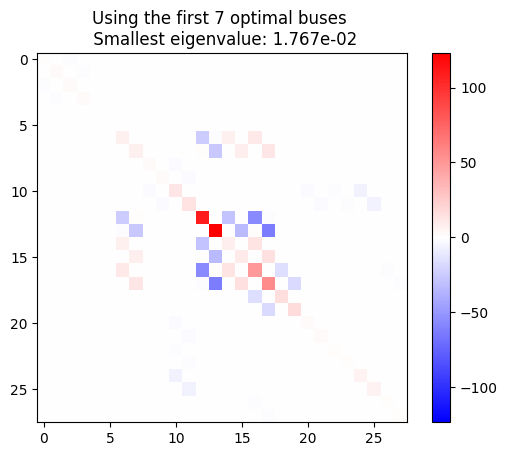

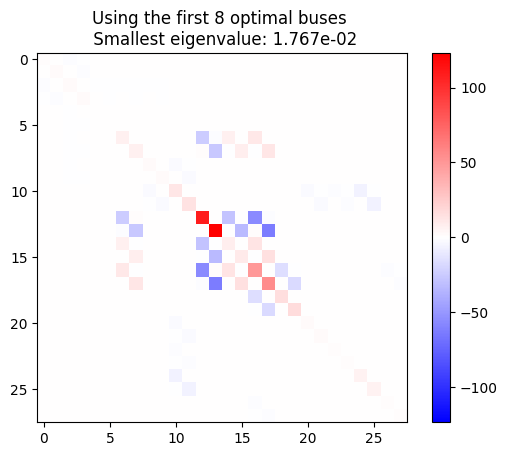

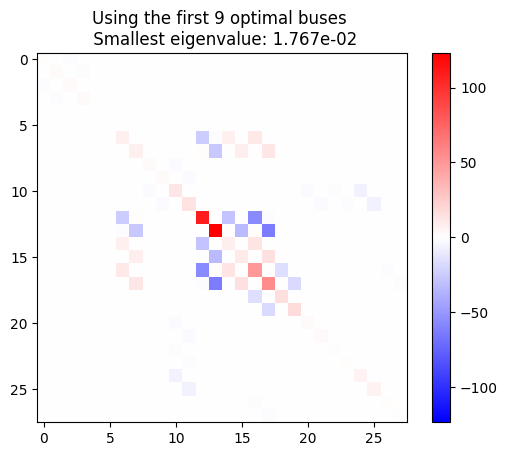

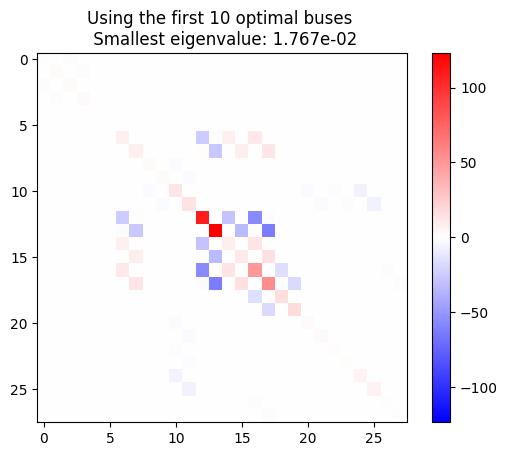

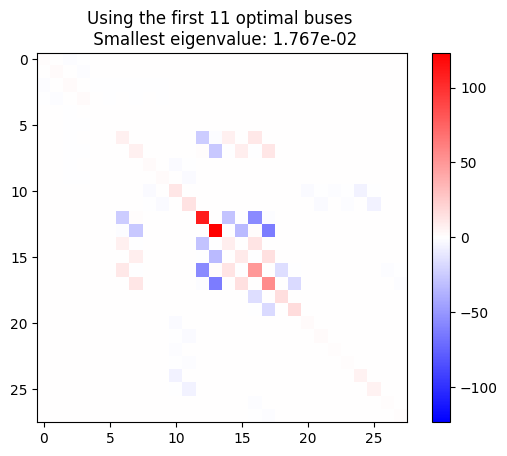

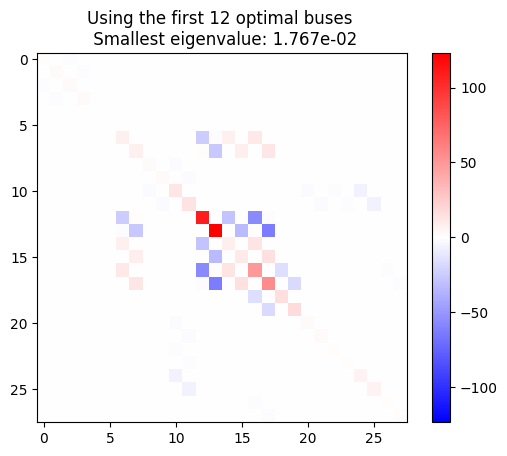

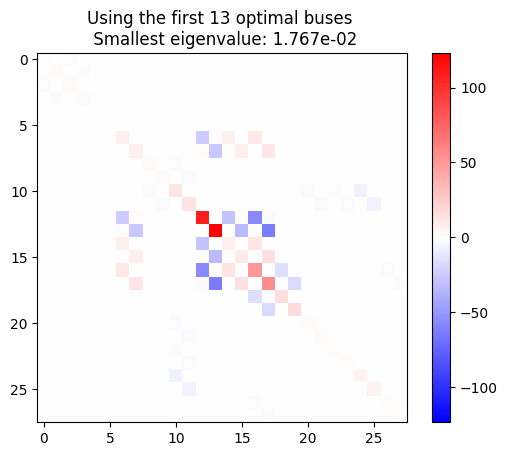

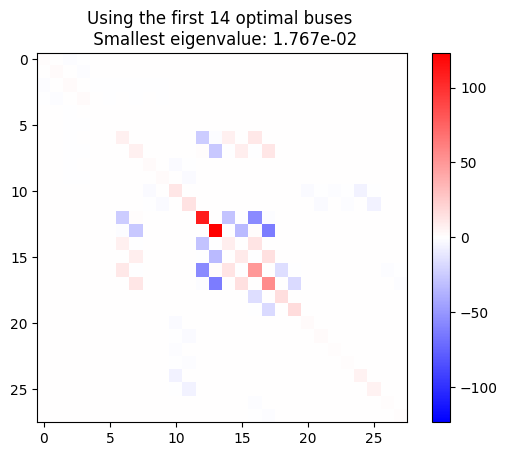

In [11]:
# FIM for each configuration, multiplied by their optimal weights
weighted_fims_configs = fim_configs_tensor * wopt.reshape((-1, 1, 1))

idx_sort = np.argsort(wopt)[::-1]
print("Buses sorted by weight magnitude: \n", configs[idx_sort])

for ii in np.arange(nconfigs) + 1:
    idx = idx_sort[:ii]
    I = np.sum(weighted_fims_configs[idx], axis=0)
    plt.figure()
    plt.title(
        f"Using the first {ii} optimal buses \n "
        + f"Smallest eigenvalue: {np.min(np.linalg.eigvalsh(I)):0.3e}"
    )
    cbound = np.max([-np.min(I), np.max(I)])
    plt.imshow(I, vmin=-cbound, vmax=cbound, cmap="bwr")
    plt.colorbar()
plt.show()

Notice that without these 3 optimal configurations, the smallest eigenvalue of the FIM is still lower than the cutoff.
However, as we have more than 3 configurations, the smallest eigenvalue doesn't really increase.

Note: Even though the smallest eigenvalue listed here when we have 3 or more configurations are smaller than the cutoff, but they are pretty close.
We believe this is just numerical artifact.